# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import numpy as np

In [2]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

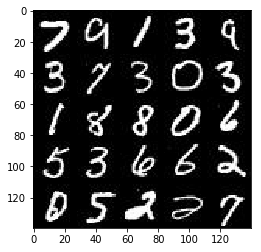

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

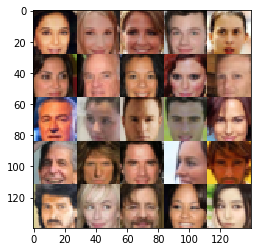

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

**Note:**

[tensorflow convolution](https://www.tensorflow.org/versions/r1.0/api_guides/python/nn#Convolution)

For the 'SAME' padding, the output height and width are computed as:

```python
out_height = ceil(float(in_height) / float(strides[1]))

out_width  = ceil(float(in_width) / float(strides[2]))
```

For the 'VALID' padding, the output height and width are computed as:
```python
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))

out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
```

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)   
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels= tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

**data_shape:**

mnist_dataset.shape: -,28,28,1

celeba_dataset.shape: -,28,28,3

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learning_rate_placeholder = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    n_images=20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_placeholder: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
#                     gen_samples = sess.run(
#                                    generator(net.input_z, 3, reuse=True, training=False),
#                                    feed_dict={net.input_z: sample_z})
#                     samples.append(gen_samples)
                    
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')

#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
#     return losses, samples                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 2.4946
Epoch 1/2... Discriminator Loss: 0.4206... Generator Loss: 2.7775
Epoch 1/2... Discriminator Loss: 0.4049... Generator Loss: 3.1676
Epoch 1/2... Discriminator Loss: 0.3833... Generator Loss: 6.5067
Epoch 1/2... Discriminator Loss: 5.6115... Generator Loss: 0.0070
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 14.6222
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 2.7569
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 3.1315


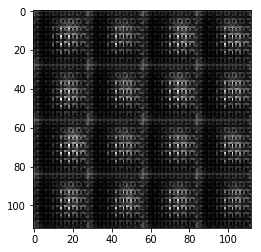

Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 4.0623
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 1.9220
Epoch 1/2... Discriminator Loss: 0.4641... Generator Loss: 2.6974
Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 2.5835
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 2.1846
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 2.6083
Epoch 1/2... Discriminator Loss: 0.4396... Generator Loss: 2.9894
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 3.8335
Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 3.2684
Epoch 1/2... Discriminator Loss: 0.4316... Generator Loss: 4.4196


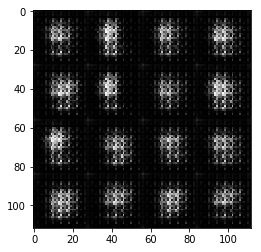

Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 3.4827
Epoch 1/2... Discriminator Loss: 0.5342... Generator Loss: 2.7272
Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 2.4844
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 5.0516
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.8380
Epoch 1/2... Discriminator Loss: 0.4789... Generator Loss: 3.2630
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 2.1380
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 1.9758
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 0.8944


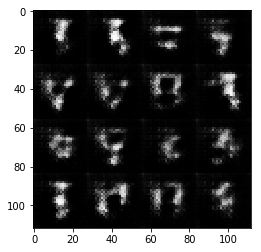

Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 2.0770
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.5797
Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 1.3365
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.8736
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.9318


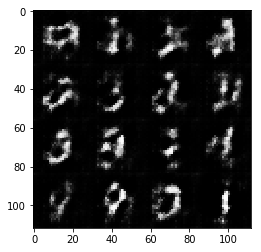

Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.2995
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 3.1020
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.3789
Epoch 1/2... Discriminator Loss: 0.8274... Generator Loss: 1.2386
Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 2.1033
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 1.1007... Generator Loss: 2.4159
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.8473


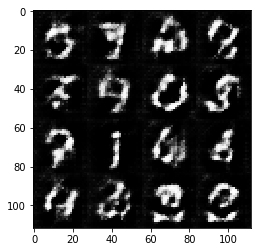

Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.4328
Epoch 1/2... Discriminator Loss: 0.9216... Generator Loss: 1.7162
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.3018
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.8507
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.0457
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.5366
Epoch 1/2... Discriminator Loss: 0.7730... Generator Loss: 1.5369
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 0.8667
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.6595


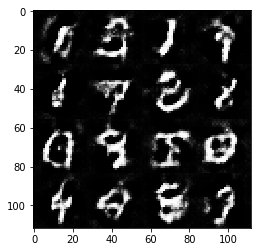

Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.7953
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.4627
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.5079
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.6467
Epoch 1/2... Discriminator Loss: 1.2401... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 2.1037
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 2.3085
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 1.2735
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 0.8428


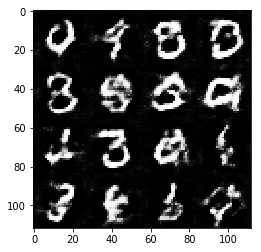

Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.1978
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.3947
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.2358
Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 1.2227
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 1.9656
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 2.2376
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 0.8172


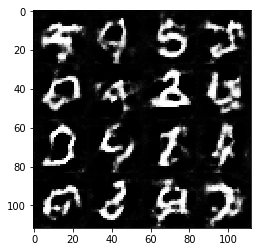

Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.4757
Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.8990
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 2.2248
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 2.0586
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 0.8360


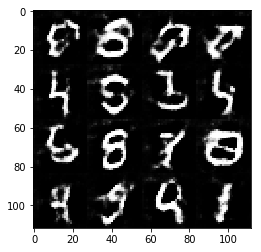

Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 1.5299
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.1526
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 2.1147
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.4339
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 1.2476
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.5432
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 1.4686
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.8742


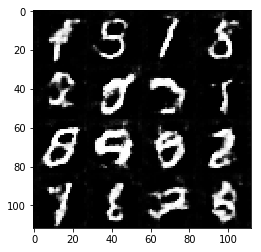

Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.2897
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.8501
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 0.8643... Generator Loss: 1.0625
Epoch 2/2... Discriminator Loss: 2.2792... Generator Loss: 3.3131


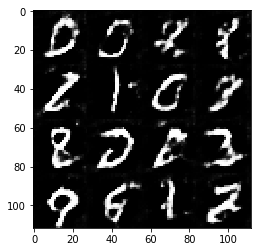

Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.3286
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 0.8310
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 1.0065
Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 0.4914
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.1929
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.2553


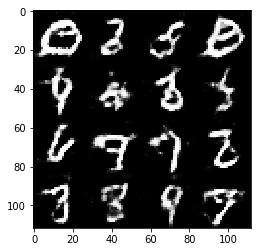

Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.2075
Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 2.2740
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.5480
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 1.1860
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.9122


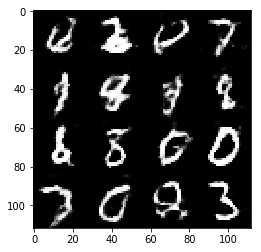

Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.4040
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.5480
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.7262
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.0345
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 2.0242
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.5097


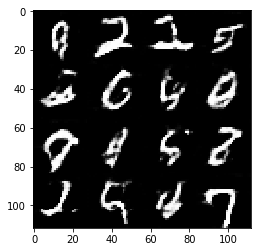

Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.8574
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.4412
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 5.2210... Generator Loss: 0.0202
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 1.2379
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 1.2883
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.4606


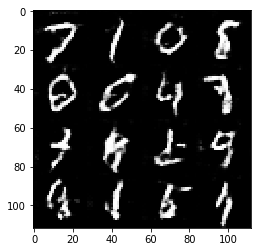

Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.0474
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.6171
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.7337... Generator Loss: 0.3886
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.1184
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.4710
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.2762
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.9144
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 1.1302


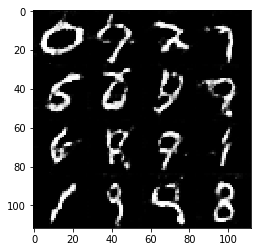

Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 2.3689
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.2766
Epoch 2/2... Discriminator Loss: 0.7446... Generator Loss: 1.6488
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 1.4868
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.2334
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.7231
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 1.4749


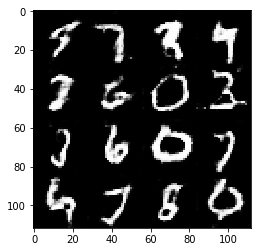

Epoch 2/2... Discriminator Loss: 1.6231... Generator Loss: 3.4885
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.2181
Epoch 2/2... Discriminator Loss: 0.8708... Generator Loss: 1.0762
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.2853
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 2.0584
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 2.9557
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.4046


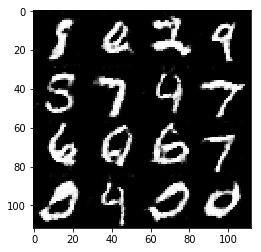

Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.5658
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.2484
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.2703
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 0.9648
Epoch 2/2... Discriminator Loss: 0.7260... Generator Loss: 1.3930


In [ ]:
batch_size = 64 #32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 2.1368
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 2.3940
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 2.0103
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 11.9529
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 2.4261
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 7.7423
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.3816


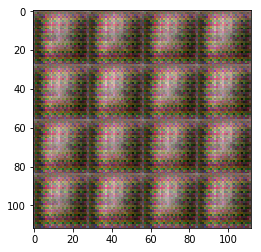

Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.1677
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 2.3618
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 2.0865
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.7627
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 3.0552
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 2.9557
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.3099
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.3467
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 3.9631
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 3.2261


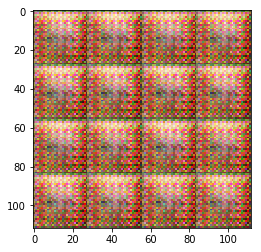

Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 2.9339
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 1.9666
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 3.0122
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 2.2496
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 3.5903
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 3.2286
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.4239
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 2.1843
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 4.9114


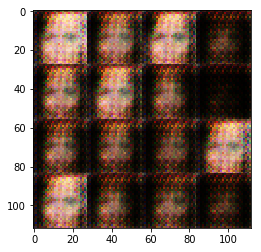

Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 5.1526
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 2.0597
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.7597
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 4.4455
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.3282
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.1795


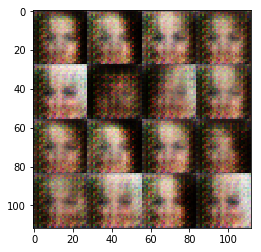

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.0932
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 3.0723
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.7607


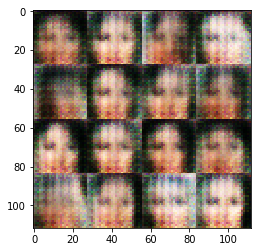

Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 2.9429
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6308


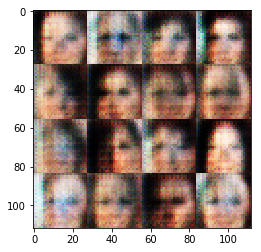

Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.5892
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.5860
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.7574
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.9562
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.5611


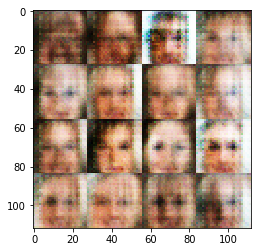

Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.4001
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.9087


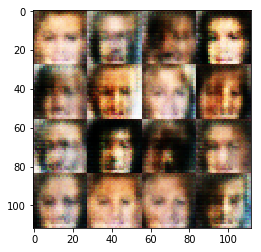

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 2.7697
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.4179


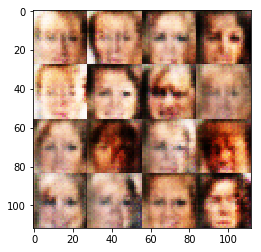

Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 1.0338


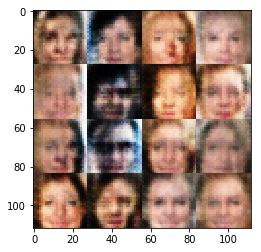

Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7729


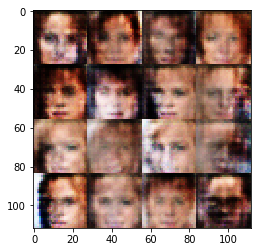

Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.6802
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.4173


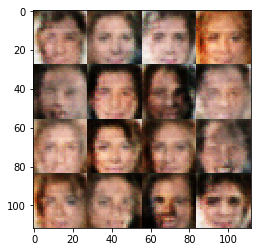

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 2.7320
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8180


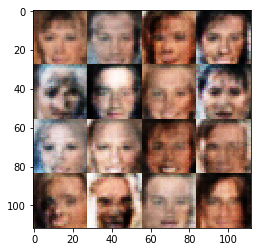

Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6371


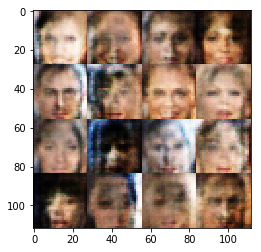

Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.9249


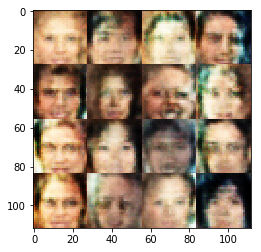

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.8180


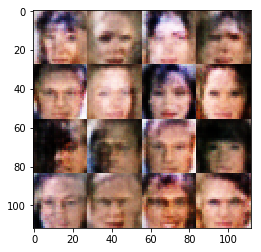

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6134


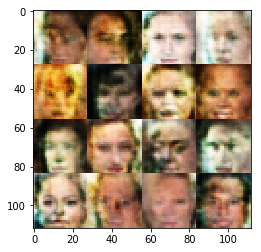

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 1.6033
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.9109


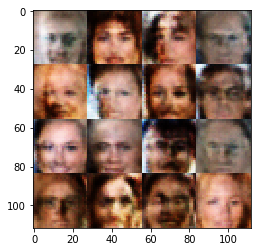

Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.1360


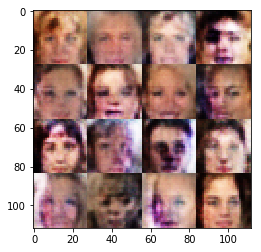

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.9943


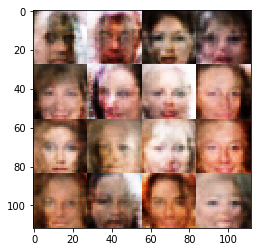

Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 1.4642


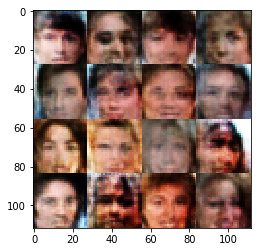

Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.3713


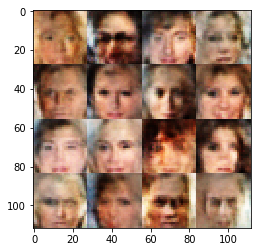

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.6399
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.9094


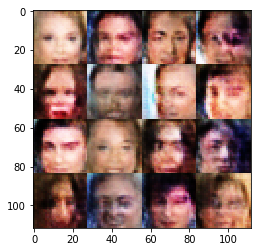

Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.6797


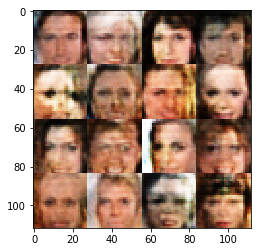

Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.9635


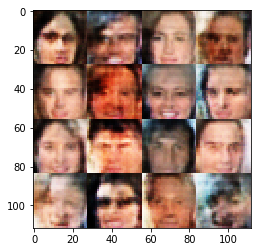

Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.2888
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7643


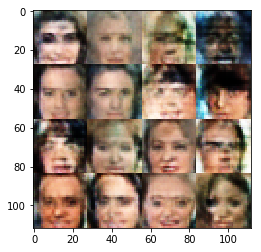

Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.3168


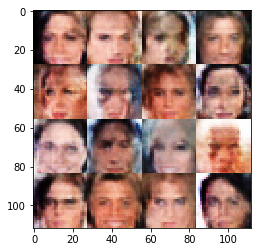

Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.8622
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.5859


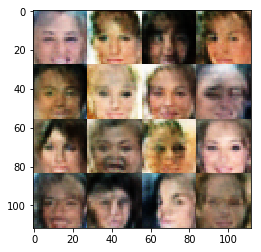

Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8420


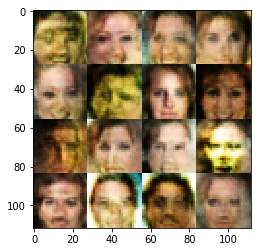

Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.7726


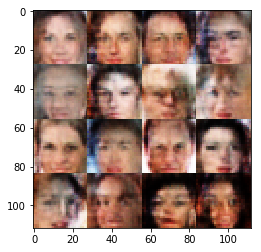

Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.5789


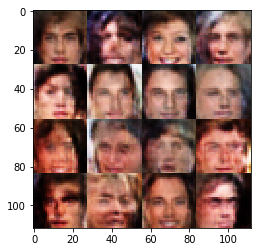

Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.1263


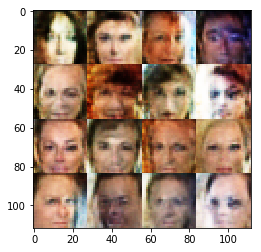

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.4212
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.4678
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.9008


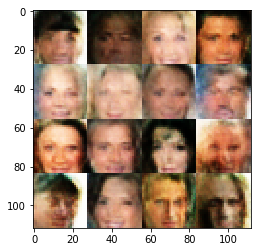

Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.2883
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6412


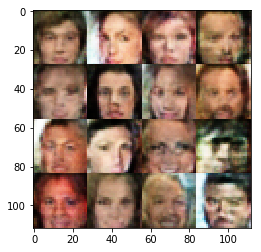

Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.5098
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.4848


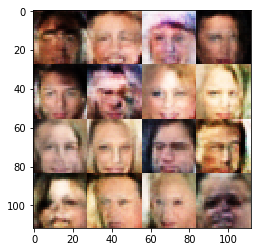

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0568


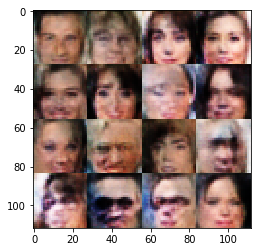

Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.1318
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.1799


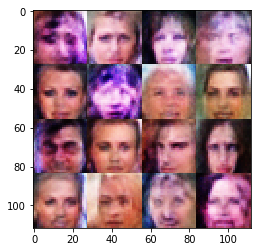

Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.1301


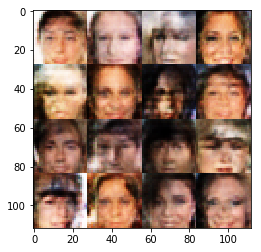

Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.6355
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6221


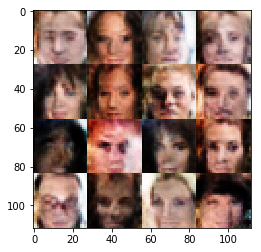

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7415


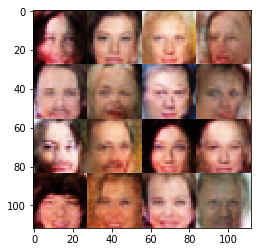

Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0290


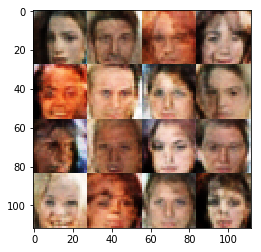

Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.5370


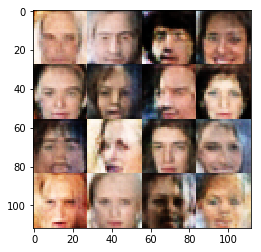

Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.8511... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.6793
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3212


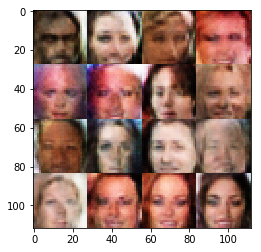

Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.6264


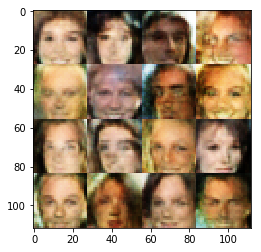

Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.4283
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.4769
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6127


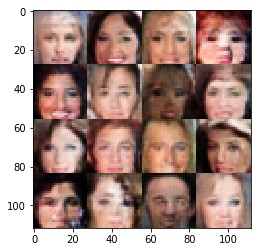

Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.6366
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.7072


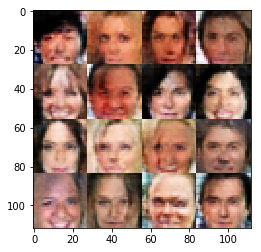

Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.7745
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 0.9790


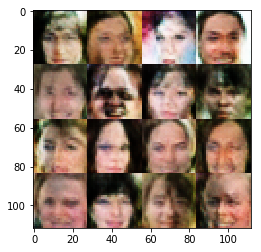

Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.5715


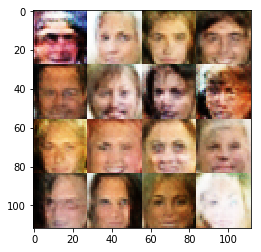

Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.5229
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.4678


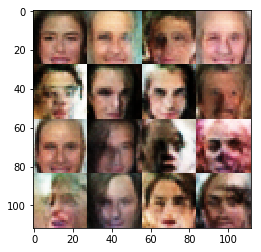

Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6050


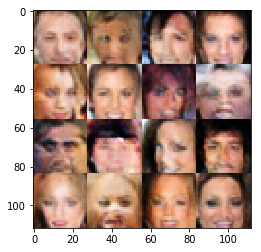

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.7254... Generator Loss: 0.3205
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 1.9527


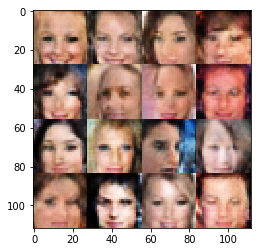

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.3626
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.2530


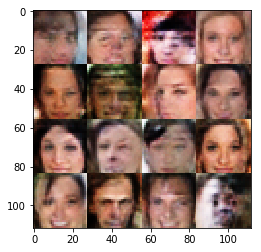

Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.1530


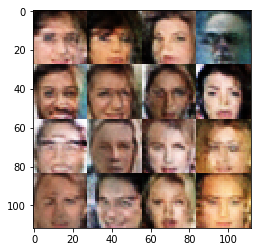

Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.9620
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.5319
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.9804


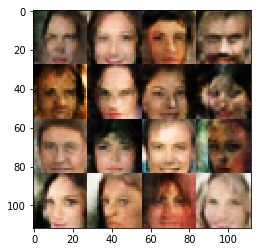

Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.5876
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5748


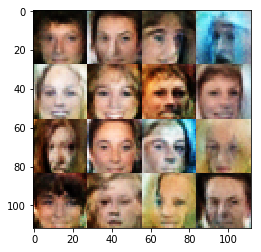

Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.5998
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.5056


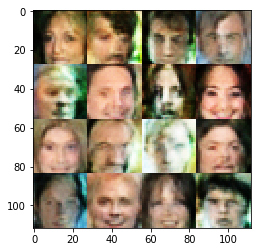

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.7529


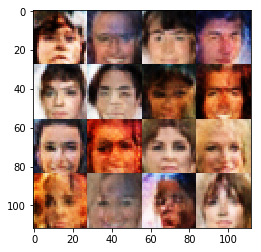

Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.6602
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.2027


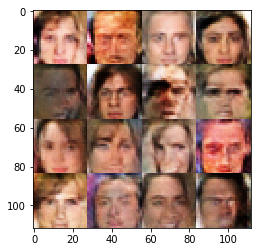

Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.7186
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.0669


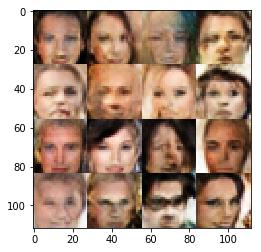

Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.7332... Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.8200


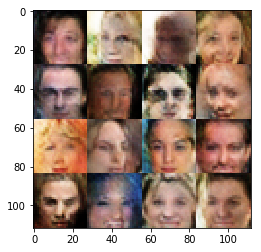

Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.0042


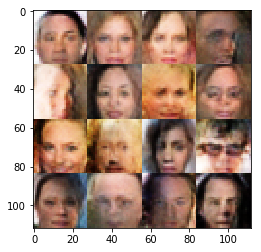

Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.7788... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7622


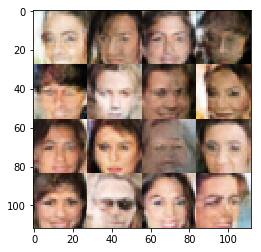

Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.9752


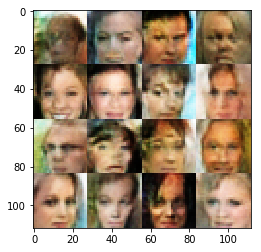

Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6872


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.